<a href="https://colab.research.google.com/github/Rida-Zubair/Rida-Zubair/blob/main/i23_2590_Assignment1_DS_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Important Rules and Restrictions**

Use of the following libraries is strictly prohibited:

- NLTK  
- spaCy  
- HuggingFace Tokenizers  
- SentencePiece  
- Urduhack  
- Stanza  
- Polyglot  
- Gensim Language Models  
- sklearn CountVectorizer / TfidfVectorizer  

Violation will result in zero marks.

### **Allowed Libraries**
Students may use:

- Python Standard Functions
- Regex  
- NumPy  
- Pandas  
- BeautifulSoup / Requests / Scrapy / Selenium (For use of Scraping only)  
- Matplotlib  

## **Part 1: BBC Urdu Dataset Collection and Preprocessing**
In this part, BBC Urdu news articles are collected and prepared into a clean dataset using normalization and custom preprocessing tools. The output of this part will be reused directly in Part 2.

News articles must be scraped from:
https://www.bbc.com/urdu

Students must scrape:
- Minimum: 200 articles
- Maximum: 300 articles

Each article must be complete and properly structured.

Article metadata must be stored in a JSON file with the following constraints:
- Each article must be numbered
- Article numbers must be unique
- Article numbers must match TXT files
- Article body must not be included

### ***Format Example***
```json
{
  "1": {
    "title": "پاکستان میں مہنگائی کی شرح میں اضافہ",
    "publish_date": "2024-01-15"
  },
  "2": {
    "title": "کراچی میں بارش کے بعد صورتحال",
    "publish_date": "2024-02-02"
  }
}

In [ ]:
import requests
from bs4 import BeautifulSoup
import json
import time
import re
from urllib.parse import urljoin
from datetime import datetime, timedelta

def scrape_bbc_urdu_articles(target_count=300):
    """Scrape BBC Urdu articles using multiple strategies"""
    BASE_URL = "https://www.bbc.com"

    article_links = set()
    metadata = {}
    raw_articles = {}

    print("Strategy 1: Scraping from topic pages with pagination...")

    # BBC Urdu topics with potential pagination
    topics = [
        "c2dwqd2ygdxt",  # Pakistan
        "c06gq9v4xp3t",  # World
        "c40379e2ymxt",  # India
        "c9wpm0en87xt",  # Sports
        "c2lej05epw5t",  # Entertainment
        "ckdxnx900n5t",  # Science & Tech
        "c4794229lwwt",  # Health
    ]

    # Try to get articles from each topic with page parameter
    for topic in topics:
        for page in range(1, 15):  # Try up to 15 pages per topic
            try:
                # Try different URL patterns
                urls_to_try = [
                    f"https://www.bbc.com/urdu/topics/{topic}?page={page}",
                    f"https://www.bbc.com/urdu/topics/{topic}/page/{page}",
                ]

                for url in urls_to_try:
                    try:
                        res = requests.get(url, timeout=15)
                        if res.status_code != 200:
                            continue

                        soup = BeautifulSoup(res.text, "html.parser")

                        # Find article links
                        found_new = False
                        for a in soup.find_all("a", href=True):
                            href = a['href']
                            if "/urdu/articles/" in href:
                                if href.startswith('/'):
                                    link = urljoin(BASE_URL, href)
                                else:
                                    link = href

                                if link not in article_links:
                                    article_links.add(link)
                                    found_new = True

                        if found_new:
                            print(f"  Topic {topic}, page {page}: {len(article_links)} total links")

                        time.sleep(0.5)

                        if not found_new:
                            break  # No new articles, move to next topic

                    except:
                        continue

                if len(article_links) >= target_count * 2:
                    break

            except Exception as e:
                continue

        if len(article_links) >= target_count * 2:
            break

    print(f"\nStrategy 2: Scraping from date-based archives...")

    # Try date-based URLs
    if len(article_links) < target_count * 1.5:
        today = datetime.now()
        for days_back in range(0, 180, 7):  # Go back 6 months, weekly
            date = today - timedelta(days=days_back)
            date_str = date.strftime("%Y/%m/%d")

            try:
                url = f"https://www.bbc.com/urdu/{date_str}"
                res = requests.get(url, timeout=10)
                if res.status_code == 200:
                    soup = BeautifulSoup(res.text, "html.parser")
                    for a in soup.find_all("a", href=True):
                        if "/urdu/articles/" in a['href']:
                            link = urljoin(BASE_URL, a['href'])
                            article_links.add(link)

                    if len(article_links) % 50 == 0:
                        print(f"  Checked {days_back} days back: {len(article_links)} links")

                time.sleep(0.3)

                if len(article_links) >= target_count * 2:
                    break

            except:
                continue

    print(f"\nStrategy 3: Following 'More Stories' and related links...")

    # Scrape a few articles to find related links
    if len(article_links) < target_count * 1.5:
        sample_articles = list(article_links)[:30]
        for article_url in sample_articles:
            try:
                res = requests.get(article_url, timeout=10)
                soup = BeautifulSoup(res.text, "html.parser")

                # Look for related articles sections
                related_sections = soup.find_all(['div', 'section'],
                    class_=re.compile(r'.*related.*|.*more.*|.*recommend.*', re.I))

                for section in related_sections:
                    for a in section.find_all("a", href=True):
                        if "/urdu/articles/" in a['href']:
                            link = urljoin(BASE_URL, a['href'])
                            article_links.add(link)

                time.sleep(0.5)

                if len(article_links) >= target_count * 2:
                    break

            except:
                continue

        print(f"  Found {len(article_links)} total links through related articles")

    article_links = list(article_links)
    print(f"\n{'='*60}")
    print(f"Total unique article links found: {len(article_links)}")
    print(f"{'='*60}\n")

    # Scrape articles
    print(f"Phase: Scraping articles (target: {target_count})...\n")

    article_id = 1
    failed_count = 0

    for idx, link in enumerate(article_links):
        if article_id > target_count:
            break

        try:
            print(f"Scraping {article_id}/{target_count} (tried {idx+1}/{len(article_links)})...", end='\r')
            r = requests.get(link, timeout=15)
            s = BeautifulSoup(r.text, "html.parser")

            # Extract title
            title_tag = s.find("h1") or s.find("h2", class_=re.compile(r'.*title.*', re.I))
            if not title_tag:
                failed_count += 1
                continue

            title = title_tag.text.strip()

            # Extract date
            date_tag = s.find("time")
            publish_date = ""
            if date_tag:
                publish_date = date_tag.get('datetime', '') or date_tag.text.strip()

            # Extract body
            body_tags = []
            article_body = s.find(['article', 'main'], class_=re.compile(r'.*article.*|.*story.*', re.I))
            if article_body:
                body_tags = article_body.find_all("p")

            if not body_tags:
                body_tags = s.find_all("p", class_=re.compile(r'.*text.*|.*paragraph.*', re.I))

            if not body_tags:
                body_tags = s.find_all("p")

            paragraphs = []
            for p in body_tags:
                text = p.text.strip()
                if (len(text) > 30 and
                    'bbc' not in text.lower()[:20] and
                    'copyright' not in text.lower()):
                    paragraphs.append(text)

            body_text = "\n".join(paragraphs)

            # Save if substantial
            if len(body_text) > 300 and title and len(paragraphs) >= 3:
                metadata[str(article_id)] = {
                    "title": title,
                    "publish_date": publish_date
                }
                raw_articles[article_id] = body_text
                article_id += 1
            else:
                failed_count += 1

            time.sleep(0.5)

        except Exception as e:
            failed_count += 1
            continue

    print(f"\n\n{'='*60}")
    print(f"Successfully scraped: {len(metadata)} articles")
    print(f"Failed/skipped: {failed_count} articles")
    print(f"{'='*60}")

    return metadata, raw_articles

# Execute scraping
print("Starting BBC Urdu article scraper...")
print("="*60)
metadata, raw_articles = scrape_bbc_urdu_articles(target_count=300)

# Save metadata JSON
with open("metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print(f"\n✓ Saved metadata for {len(metadata)} articles to metadata.json")
print(f"✓ Collected {len(raw_articles)} article bodies")

# Show sample
if metadata:
    print(f"\nSample article:")
    first_id = list(metadata.keys())[0]
    print(f"  Title: {metadata[first_id]['title']}")
    print(f"  Date: {metadata[first_id]['publish_date']}")
    print(f"  Body length: {len(raw_articles[int(first_id)])} characters")

Starting BBC Urdu article scraper...
Strategy 1: Scraping from topic pages with pagination...
  Topic c40379e2ymxt, page 1: 24 total links
  Topic c40379e2ymxt, page 2: 48 total links
  Topic c40379e2ymxt, page 3: 72 total links
  Topic c40379e2ymxt, page 4: 96 total links
  Topic c40379e2ymxt, page 5: 120 total links
  Topic c40379e2ymxt, page 6: 144 total links
  Topic c40379e2ymxt, page 7: 168 total links
  Topic c40379e2ymxt, page 8: 192 total links
  Topic c40379e2ymxt, page 9: 216 total links
  Topic c40379e2ymxt, page 10: 240 total links
  Topic c40379e2ymxt, page 11: 264 total links
  Topic c40379e2ymxt, page 12: 288 total links
  Topic c40379e2ymxt, page 13: 312 total links
  Topic c40379e2ymxt, page 14: 336 total links
  Topic ckdxnx900n5t, page 1: 355 total links
  Topic ckdxnx900n5t, page 2: 373 total links
  Topic ckdxnx900n5t, page 3: 395 total links
  Topic ckdxnx900n5t, page 4: 419 total links
  Topic ckdxnx900n5t, page 5: 443 total links
  Topic ckdxnx900n5t, page 6: 4

### ***raw.txt File***
This file must contain:
- Raw scraped article content
- No cleaning or normalization
- One article per block
- Each article must start with its article number

### ***Example***
```json
[1]
یہ خبر بی بی سی اردو سے حاصل کی گئی ہے...

[2]
کراچی میں بارش کے بعد صورتحال خراب ہو گئی...

In [ ]:
# Save raw articles to raw.txt
with open("raw.txt", "w", encoding="utf-8") as f:
    for article_id in sorted(raw_articles.keys()):
        f.write(f"[{article_id}]\n")
        f.write(raw_articles[article_id])
        f.write("\n\n")

print(f"Saved {len(raw_articles)} raw articles to raw.txt")

Saved 300 raw articles to raw.txt


## ***cleaned.txt File***

This file must contain:
- Fully preprocessed data
- Normalized Urdu text
- Noise removed
- Sentence segmented
- Ready for language model training
- Article numbering matching raw.txt and JSON

**Refer to the given Assignment PDF Document for the data cleaning and normalizing techniques**

In [ ]:
import re
import unicodedata

# ============================================================================
# STEP 1: DIACRITICS REMOVAL
# ============================================================================
# Urdu diacritics (zabar, zer, pesh, etc.) - Complete list
URDU_DIACRITICS = [
    '\u064B',  # Fathatan (double zabar)
    '\u064C',  # Dammatan (double pesh)
    '\u064D',  # Kasratan (double zer)
    '\u064E',  # Fatha (zabar)
    '\u064F',  # Damma (pesh)
    '\u0650',  # Kasra (zer)
    '\u0651',  # Shadda (tashdeed)
    '\u0652',  # Sukun (jazm)
    '\u0653',  # Maddah
    '\u0654',  # Hamza above
    '\u0655',  # Hamza below
    '\u0656',  # Subscript alef
    '\u0657',  # Inverted damma
    '\u0658',  # Mark noon ghunna
    '\u0670',  # Superscript alef
]

def remove_diacritics(text):
    """
    Remove all Urdu diacritical marks from text.
    Diacritics are pronunciation marks that are inconsistently used.
    Removing them ensures uniform word representation.

    Example: عِلم -> علم
    """
    original_length = len(text)

    # Remove each diacritic
    for diacritic in URDU_DIACRITICS:
        text = text.replace(diacritic, '')

    # Also use Unicode normalization to catch any remaining combining marks
    text = ''.join(char for char in text if unicodedata.category(char) != 'Mn')

    removed = original_length - len(text)
    if removed > 0:
        print(f"  Removed {removed} diacritic marks")

    return text


# ============================================================================
# STEP 2: NOISE REMOVAL
# ============================================================================

def remove_urls(text):
    """Remove all URLs and web addresses"""
    # Remove http/https URLs
    text = re.sub(r'https?://\S+', '', text)
    # Remove www URLs
    text = re.sub(r'www\.\S+', '', text)
    # Remove domain-like patterns
    text = re.sub(r'\S+\.com\S*', '', text)
    text = re.sub(r'\S+\.org\S*', '', text)
    text = re.sub(r'\S+\.net\S*', '', text)
    return text

def remove_email_addresses(text):
    """Remove email addresses"""
    text = re.sub(r'\S+@\S+\.\S+', '', text)
    return text

def remove_special_characters(text):
    """
    Remove special characters, symbols, and emojis.
    Keep Urdu punctuation marks (۔ ؟ ، ٪)
    """
    # Remove emojis (comprehensive range)
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub('', text)

    # Remove special symbols but keep Urdu punctuation
    text = re.sub(r'[#@$%^&*()_+=\[\]{}|\\<>~`"\']', '', text)

    # Remove mathematical symbols
    text = re.sub(r'[×÷±≠≈∞√∑∫]', '', text)

    return text

def remove_bbc_artifacts(text):
    """
    Remove BBC-specific text artifacts like:
    - Copyright notices
    - Navigation text
    - Image captions
    - Social media prompts
    """
    # Common BBC Urdu artifacts
    artifacts = [
        r'©.*?بی بی سی.*',
        r'بی بی سی.*?ذمہ دار نہیں.*',
        r'تصویر کا ذریعہ.*',
        r'تصویر کا کیپشن.*',
        r'End of.*',
        r'سب سے زیادہ پڑھی جانے والی.*',
        r'بی بی سی اردو کی خبروں.*?معنی رکھتی ہیں',
        r'بیرونی لنکس کے بارے میں.*',
    ]

    for artifact in artifacts:
        text = re.sub(artifact, '', text, flags=re.IGNORECASE)

    return text

def remove_noise(text):
    """Apply all noise removal steps"""
    print("  Removing noise...")
    text = remove_urls(text)
    text = remove_email_addresses(text)
    text = remove_bbc_artifacts(text)
    text = remove_special_characters(text)
    return text


# ============================================================================
# STEP 3: NON-URDU TEXT REMOVAL
# ============================================================================

def remove_english_text(text):
    """
    Remove English letters and Roman Urdu.
    Keep only Urdu script characters.
    """
    # Remove English letters (both cases)
    text = re.sub(r'[a-zA-Z]+', '', text)
    return text

def keep_only_urdu_script(text):
    """
    Keep only Urdu/Arabic script characters, numbers, and Urdu punctuation.
    Unicode ranges:
    - 0600-06FF: Arabic (includes Urdu)
    - 0750-077F: Arabic Supplement
    - FB50-FDFF: Arabic Presentation Forms-A
    - FE70-FEFF: Arabic Presentation Forms-B
    """
    # Define what to keep
    urdu_pattern = r'[\u0600-\u06FF\u0750-\u077F\uFB50-\uFDFF\uFE70-\uFEFF\s\d۔؟،٪!\-]'

    # Extract only matching characters
    urdu_chars = re.findall(urdu_pattern, text)
    return ''.join(urdu_chars)

def remove_non_urdu(text):
    """Remove all non-Urdu text"""
    print("  Removing non-Urdu text...")
    text = remove_english_text(text)
    text = keep_only_urdu_script(text)
    return text


# ============================================================================
# STEP 4: SENTENCE SEGMENTATION
# ============================================================================

def segment_sentences(text):
    """
    Segment text into sentences using Urdu punctuation marks.
    Urdu sentence endings: ۔ (full stop), ؟ (question mark), ! (exclamation)
    """
    print("  Segmenting sentences...")

    # Split on Urdu sentence terminators
    sentences = re.split(r'[۔؟!]+', text)

    # Clean each sentence
    cleaned_sentences = []
    for sent in sentences:
        sent = sent.strip()
        # Keep sentences with at least 3 words
        if sent and len(sent.split()) >= 3:
            cleaned_sentences.append(sent)

    # Rejoin with Urdu full stop and space
    if cleaned_sentences:
        result = '۔ '.join(cleaned_sentences) + '۔'
        print(f"  Created {len(cleaned_sentences)} sentences")
        return result
    return ''


# ============================================================================
# STEP 5: WHITESPACE NORMALIZATION
# ============================================================================

def normalize_whitespace(text):
    """
    Normalize all whitespace:
    - Replace multiple spaces with single space
    - Remove leading/trailing whitespace
    - Normalize line breaks
    """
    # Replace multiple spaces with single space
    text = re.sub(r' +', ' ', text)

    # Replace multiple line breaks
    text = re.sub(r'\n+', ' ', text)

    # Remove tabs
    text = text.replace('\t', ' ')

    # Remove leading/trailing whitespace
    text = text.strip()

    # Ensure proper spacing after Urdu punctuation
    text = re.sub(r'([۔؟،])([^\s])', r'\1 \2', text)

    return text


# ============================================================================
# MASTER CLEANING FUNCTION
# ============================================================================

def clean_article(text, article_id=None):
    """
    Apply all cleaning steps to an article in sequence.
    Returns cleaned text ready for tokenization.
    """
    if article_id:
        print(f"\nCleaning Article {article_id}:")

    original_length = len(text)

    # Step 1: Remove diacritics
    text = remove_diacritics(text)

    # Step 2: Remove noise
    text = remove_noise(text)

    # Step 3: Remove non-Urdu text
    text = remove_non_urdu(text)

    # Step 4: Normalize whitespace
    text = normalize_whitespace(text)

    # Step 5: Segment sentences
    text = segment_sentences(text)

    final_length = len(text)
    reduction = ((original_length - final_length) / original_length * 100) if original_length > 0 else 0

    if article_id:
        print(f"  Original: {original_length} chars → Cleaned: {final_length} chars")
        print(f"  Reduction: {reduction:.1f}%")

    return text


# ============================================================================
# CLEAN ALL ARTICLES
# ============================================================================

print("="*70)
print("STARTING DATA CLEANING PROCESS")
print("="*70)

cleaned_articles = {}
total_original_chars = 0
total_cleaned_chars = 0

# Show detailed cleaning for first 3 articles
for article_id, raw_text in list(raw_articles.items())[:3]:
    cleaned_text = clean_article(raw_text, article_id)
    cleaned_articles[article_id] = cleaned_text
    total_original_chars += len(raw_text)
    total_cleaned_chars += len(cleaned_text)

# Clean remaining articles without detailed output
print(f"\nCleaning remaining {len(raw_articles) - 3} articles...")
for article_id, raw_text in list(raw_articles.items())[3:]:
    cleaned_text = clean_article(raw_text)
    cleaned_articles[article_id] = cleaned_text
    total_original_chars += len(raw_text)
    total_cleaned_chars += len(cleaned_text)

    # Progress indicator
    if article_id % 10 == 0:
        print(f"  Processed {article_id}/{len(raw_articles)} articles...", end='\r')

print("\n" + "="*70)
print("CLEANING SUMMARY")
print("="*70)
print(f"Total articles cleaned: {len(cleaned_articles)}")
print(f"Total original characters: {total_original_chars:,}")
print(f"Total cleaned characters: {total_cleaned_chars:,}")
print(f"Overall reduction: {((total_original_chars - total_cleaned_chars) / total_original_chars * 100):.1f}%")

# Show sample of cleaned text
print("\n" + "="*70)
print("SAMPLE CLEANED TEXT (Article 1):")
print("="*70)
if 1 in cleaned_articles:
    sample = cleaned_articles[1][:400]
    print(sample)
    print(f"\n... (showing first 400 characters of {len(cleaned_articles[1])} total)")
print("="*70)

STARTING DATA CLEANING PROCESS

Cleaning Article 1:
  Removed 6 diacritic marks
  Removing noise...
  Removing non-Urdu text...
  Segmenting sentences...
  Created 141 sentences
  Original: 12358 chars → Cleaned: 11959 chars
  Reduction: 3.2%

Cleaning Article 2:
  Removed 2 diacritic marks
  Removing noise...
  Removing non-Urdu text...
  Segmenting sentences...
  Created 51 sentences
  Original: 6591 chars → Cleaned: 6211 chars
  Reduction: 5.8%

Cleaning Article 3:
  Removing noise...
  Removing non-Urdu text...
  Segmenting sentences...
  Created 62 sentences
  Original: 6651 chars → Cleaned: 6281 chars
  Reduction: 5.6%

Cleaning remaining 297 articles...
  Removing noise...
  Removing non-Urdu text...
  Segmenting sentences...
  Created 88 sentences
  Removed 72 diacritic marks
  Removing noise...
  Removing non-Urdu text...
  Segmenting sentences...
  Created 136 sentences
  Removed 4 diacritic marks
  Removing noise...
  Removing non-Urdu text...
  Segmenting sentences...
  Cre

## ***Custom Urdu Tokenizer***

The tokenizer must handle:
- Word boundaries
- Punctuation
- Postpositions
- Numbers and special tokens

All numbers must be replaced with `<NUM>`.

Input:

پاکستان میں میں بارش ہوئی  
2024  

Output:

پاکستان | میں | میں | بارش | ہوئی  
`<NUM>`

In [ ]:
import re

class UrduTokenizer:
    """
    Custom Urdu tokenizer that handles:
    - Word boundaries
    - Urdu punctuation marks
    - Postpositions (نے، کو، سے، میں، etc.)
    - Numbers (replaced with <NUM> token)
    - Special tokens
    """

    def __init__(self):
        # Urdu punctuation marks
        self.urdu_punctuation = '۔؟،٪!'

        # Common Urdu postpositions (should be kept as separate tokens)
        self.postpositions = [
            'نے', 'کو', 'سے', 'میں', 'پر', 'کا', 'کی', 'کے',
            'تک', 'کیلیے', 'کیلئے', 'بھی', 'ہی', 'تو', 'ہے'
        ]

        # Special tokens
        self.special_tokens = {
            '<NUM>': 'number',
            '<START>': 'sentence start',
            '<END>': 'sentence end',
        }

    def replace_numbers(self, text):
        """
        Replace all numbers (both English and Urdu digits) with <NUM> token.

        Examples:
        - 2024 -> <NUM>
        - ۲۰۲۴ -> <NUM>
        - 12.5 -> <NUM>
        """
        # Replace English digits
        text = re.sub(r'\d+\.?\d*', '<NUM>', text)

        # Replace Urdu/Arabic digits (۰-۹)
        text = re.sub(r'[۰-۹]+', '<NUM>', text)

        return text

    def tokenize(self, text):
        """
        Tokenize Urdu text into words and punctuation.

        Process:
        1. Replace numbers with <NUM>
        2. Separate punctuation from words
        3. Split on whitespace
        4. Filter empty tokens

        Returns: List of tokens
        """
        # Step 1: Replace numbers
        text = self.replace_numbers(text)

        # Step 2: Add spaces around punctuation for easier splitting
        for punct in self.urdu_punctuation:
            text = text.replace(punct, f' {punct} ')

        # Step 3: Split on whitespace
        tokens = text.split()

        # Step 4: Clean tokens
        final_tokens = []
        for token in tokens:
            token = token.strip()
            if token:  # Only add non-empty tokens
                final_tokens.append(token)

        return final_tokens

    def tokenize_with_stats(self, text):
        """
        Tokenize and return statistics.
        """
        tokens = self.tokenize(text)

        stats = {
            'total_tokens': len(tokens),
            'unique_tokens': len(set(tokens)),
            'num_count': tokens.count('<NUM>'),
            'punct_count': sum(1 for t in tokens if t in self.urdu_punctuation),
            'word_count': sum(1 for t in tokens if t not in self.urdu_punctuation and t != '<NUM>')
        }

        return tokens, stats

    def detokenize(self, tokens):
        """
        Convert tokens back to text.
        Handles proper spacing around punctuation.
        """
        if not tokens:
            return ''

        result = []
        for i, token in enumerate(tokens):
            if token in self.urdu_punctuation:
                # Punctuation: no space before, space after (except at end)
                if result:
                    result[-1] += token
                else:
                    result.append(token)
                if i < len(tokens) - 1:
                    result.append('')  # Will add space
            else:
                result.append(token)

        return ' '.join(result).replace('  ', ' ').strip()


# ============================================================================
# INITIALIZE AND TEST TOKENIZER
# ============================================================================

print("="*70)
print("URDU TOKENIZER")
print("="*70)

tokenizer = UrduTokenizer()

# Test with examples
test_cases = [
    "پاکستان میں میں بارش ہوئی 2024",
    "حکومت نے 15 فروری کو اعلان کیا۔",
    "کیا آپ 100 روپے دیں گے؟"
]

print("\nTest Cases:")
print("-" * 70)
for i, test_text in enumerate(test_cases, 1):
    tokens = tokenizer.tokenize(test_text)
    print(f"\n{i}. Input:  {test_text}")
    print(f"   Tokens: {' | '.join(tokens)}")
    print(f"   Count:  {len(tokens)} tokens")


# ============================================================================
# TOKENIZE ALL CLEANED ARTICLES
# ============================================================================

print("\n" + "="*70)
print("TOKENIZING ALL ARTICLES")
print("="*70)

tokenized_articles = {}
all_stats = {
    'total_tokens': 0,
    'total_unique': 0,
    'total_numbers': 0,
    'total_punct': 0,
    'total_words': 0
}

# Tokenize first article with details
if 1 in cleaned_articles:
    print("\nDetailed tokenization of Article 1:")
    tokens, stats = tokenizer.tokenize_with_stats(cleaned_articles[1])
    tokenized_articles[1] = tokens

    print(f"  Total tokens: {stats['total_tokens']}")
    print(f"  Unique tokens: {stats['unique_tokens']}")
    print(f"  Numbers: {stats['num_count']}")
    print(f"  Punctuation: {stats['punct_count']}")
    print(f"  Words: {stats['word_count']}")
    print(f"\n  First 20 tokens: {' | '.join(tokens[:20])}")

    # Update cumulative stats
    all_stats['total_tokens'] += stats['total_tokens']
    all_stats['total_unique'] += stats['unique_tokens']
    all_stats['total_numbers'] += stats['num_count']
    all_stats['total_punct'] += stats['punct_count']
    all_stats['total_words'] += stats['word_count']

# Tokenize remaining articles
print(f"\nTokenizing remaining {len(cleaned_articles) - 1} articles...")
for article_id, text in cleaned_articles.items():
    if article_id == 1:
        continue

    tokens, stats = tokenizer.tokenize_with_stats(text)
    tokenized_articles[article_id] = tokens

    # Update cumulative stats
    all_stats['total_tokens'] += stats['total_tokens']
    all_stats['total_unique'] += stats['unique_tokens']
    all_stats['total_numbers'] += stats['num_count']
    all_stats['total_punct'] += stats['punct_count']
    all_stats['total_words'] += stats['word_count']

    if article_id % 10 == 0:
        print(f"  Processed {article_id}/{len(cleaned_articles)} articles...", end='\r')

print("\n" + "="*70)
print("TOKENIZATION SUMMARY")
print("="*70)
print(f"Articles tokenized: {len(tokenized_articles)}")
print(f"Total tokens: {all_stats['total_tokens']:,}")
print(f"Vocabulary size (unique tokens): {all_stats['total_unique']:,}")
print(f"Numbers replaced: {all_stats['total_numbers']:,}")
print(f"Punctuation marks: {all_stats['total_punct']:,}")
print(f"Word tokens: {all_stats['total_words']:,}")
print(f"Average tokens per article: {all_stats['total_tokens'] / len(tokenized_articles):.1f}")
print("="*70)

URDU TOKENIZER

Test Cases:
----------------------------------------------------------------------

1. Input:  پاکستان میں میں بارش ہوئی 2024
   Tokens: پاکستان | میں | میں | بارش | ہوئی | <NUM>
   Count:  6 tokens

2. Input:  حکومت نے 15 فروری کو اعلان کیا۔
   Tokens: حکومت | نے | <NUM> | فروری | کو | اعلان | کیا | ۔
   Count:  8 tokens

3. Input:  کیا آپ 100 روپے دیں گے؟
   Tokens: کیا | آپ | <NUM> | روپے | دیں | گے | ؟
   Count:  7 tokens

TOKENIZING ALL ARTICLES

Detailed tokenization of Article 1:
  Total tokens: 2797
  Unique tokens: 788
  Numbers: 21
  Punctuation: 175
  Words: 2601

  First 20 tokens: نوٹ | اس | تحریر | کے | کچھ | حصے | قارئین | کے | لیے | پریشانی | کا | باعث | ہو | سکتے | ہیں | معروف | امریکی | ریپر | اور | میوزک

Tokenizing remaining 299 articles...
  Processed 300/300 articles...
TOKENIZATION SUMMARY
Articles tokenized: 300
Total tokens: 467,100
Vocabulary size (unique tokens): 147,546
Numbers replaced: 3,301
Punctuation marks: 24,922
Word tokens: 438,877
Av

## ***Custom Urdu Stemmer***
The stemmer must remove common Urdu suffixes.

Input:
لڑکیوں نے کتابیں پڑھیں  

Output:
لڑکی | کتاب | پڑھ


In [ ]:
class UrduStemmer:
    """Custom Urdu stemmer to remove common suffixes"""

    def __init__(self):
        # Common Urdu suffixes (ordered by length, longest first)
        self.suffixes = [
            'یوں',  # plural/oblique
            'وں',   # plural
            'یں',   # plural feminine
            'ئیں',  # plural feminine
            'یاں',  # plural feminine
            'ئے',   # oblique
            'ئی',   # feminine
            'یں',   # plural
            'ئے',   # plural
            'وں',   # plural
            'ون',   # plural
            'ات',   # plural
            'ہے',   # verb ending
            'تھا',  # past tense
            'تھی',  # past tense feminine
            'تھے',  # past tense plural
            'گا',   # future
            'گی',   # future feminine
            'گے',   # future plural
            'ئی',   # feminine
            'یا',   # past
            'ئے',   # plural
            'ے',    # common ending
            'ی',    # feminine
            'ا',    # masculine
            'و',    # plural marker
        ]

    def stem(self, word):
        """Remove suffix from a word"""
        if len(word) <= 2:  # Don't stem very short words
            return word

        # Try to remove suffixes
        for suffix in self.suffixes:
            if word.endswith(suffix) and len(word) > len(suffix) + 1:
                return word[:-len(suffix)]

        return word

    def stem_tokens(self, tokens):
        """Stem a list of tokens"""
        return [self.stem(token) for token in tokens]

# Initialize stemmer
stemmer = UrduStemmer()

# Test stemmer
test_words = ['لڑکیوں', 'کتابیں', 'پڑھیں']
print("Stemmer Test:")
for word in test_words:
    print(f"{word} -> {stemmer.stem(word)}")

# Stem all tokenized articles
stemmed_articles = {}
for article_id, tokens in tokenized_articles.items():
    stemmed_articles[article_id] = stemmer.stem_tokens(tokens)

print(f"\nStemmed {len(stemmed_articles)} articles")

Stemmer Test:
لڑکیوں -> لڑک
کتابیں -> کتاب
پڑھیں -> پڑھ

Stemmed 300 articles


## ***Custom Urdu Lemmatizer***

The lemmatizer is restricted to:
- Plural normalization
- Gender normalization

Plural:
- لڑکیاں -> لڑکی  
- کتابوں -> کتاب  

Gender:
- اچھی -> اچھا  
- بڑی -> بڑا

In [ ]:
class UrduLemmatizer:
    """Custom Urdu lemmatizer for plural and gender normalization"""

    def __init__(self):
        # Plural to singular mappings
        self.plural_map = {
            'لڑکیاں': 'لڑکی',
            'لڑکیوں': 'لڑکی',
            'کتابیں': 'کتاب',
            'کتابوں': 'کتاب',
            'لوگوں': 'لوگ',
            'بچوں': 'بچہ',
            'عورتوں': 'عورت',
            'مردوں': 'مرد',
        }

        # Feminine to masculine mappings
        self.gender_map = {
            'اچھی': 'اچھا',
            'بڑی': 'بڑا',
            'چھوٹی': 'چھوٹا',
            'نئی': 'نیا',
            'پرانی': 'پرانا',
            'خوبصورتی': 'خوبصورت',
        }

        # Plural suffixes for pattern-based lemmatization
        self.plural_suffixes = [
            ('یاں', 'ی'),   # لڑکیاں -> لڑکی
            ('یوں', 'ی'),   # لڑکیوں -> لڑکی
            ('وں', ''),     # کتابوں -> کتاب
            ('یں', ''),     # کتابیں -> کتاب
            ('ئیں', 'ی'),   # plural feminine
        ]

        # Gender suffixes
        self.gender_suffixes = [
            ('ی', 'ا'),     # feminine to masculine
        ]

    def lemmatize(self, word):
        """Lemmatize a single word"""
        # Check direct mappings first
        if word in self.plural_map:
            return self.plural_map[word]
        if word in self.gender_map:
            return self.gender_map[word]

        # Try pattern-based plural normalization
        for suffix, replacement in self.plural_suffixes:
            if word.endswith(suffix) and len(word) > len(suffix) + 1:
                return word[:-len(suffix)] + replacement

        # Try gender normalization (be conservative)
        if len(word) > 3:
            for suffix, replacement in self.gender_suffixes:
                if word.endswith(suffix):
                    # Only apply if it looks like an adjective
                    potential = word[:-len(suffix)] + replacement
                    return potential

        return word

    def lemmatize_tokens(self, tokens):
        """Lemmatize a list of tokens"""
        return [self.lemmatize(token) for token in tokens]

# Initialize lemmatizer
lemmatizer = UrduLemmatizer()

# Test lemmatizer
test_words = ['لڑکیاں', 'کتابوں', 'اچھی', 'بڑی']
print("Lemmatizer Test:")
for word in test_words:
    print(f"{word} -> {lemmatizer.lemmatize(word)}")

# Lemmatize all tokenized articles
lemmatized_articles = {}
for article_id, tokens in tokenized_articles.items():
    lemmatized_articles[article_id] = lemmatizer.lemmatize_tokens(tokens)

print(f"\nLemmatized {len(lemmatized_articles)} articles")

Lemmatizer Test:
لڑکیاں -> لڑکی
کتابوں -> کتاب
اچھی -> اچھا
بڑی -> بڑا

Lemmatized 300 articles


### ***Mandatory Deliverables for Part 1***
- JSON metadata file
- raw.txt
- cleaned.txt
- Tokenized dataset
- Stemmed dataset
- Lemmatized dataset


In [ ]:
# Save cleaned articles to cleaned.txt
with open("cleaned.txt", "w", encoding="utf-8") as f:
    for article_id in sorted(cleaned_articles.keys()):
        f.write(f"[{article_id}]\n")
        f.write(cleaned_articles[article_id])
        f.write("\n\n")

# Save tokenized dataset
with open("tokenized.txt", "w", encoding="utf-8") as f:
    for article_id in sorted(tokenized_articles.keys()):
        f.write(f"[{article_id}]\n")
        f.write(' '.join(tokenized_articles[article_id]))
        f.write("\n\n")

# Save stemmed dataset
with open("stemmed.txt", "w", encoding="utf-8") as f:
    for article_id in sorted(stemmed_articles.keys()):
        f.write(f"[{article_id}]\n")
        f.write(' '.join(stemmed_articles[article_id]))
        f.write("\n\n")

# Save lemmatized dataset
with open("lemmatized.txt", "w", encoding="utf-8") as f:
    for article_id in sorted(lemmatized_articles.keys()):
        f.write(f"[{article_id}]\n")
        f.write(' '.join(lemmatized_articles[article_id]))
        f.write("\n\n")

print("✓ Saved all deliverables:")
print("  - metadata.json")
print("  - raw.txt")
print("  - cleaned.txt")
print("  - tokenized.txt")
print("  - stemmed.txt")
print("  - lemmatized.txt")
print(f"\nTotal articles processed: {len(metadata)}")

✓ Saved all deliverables:
  - metadata.json
  - raw.txt
  - cleaned.txt
  - tokenized.txt
  - stemmed.txt
  - lemmatized.txt

Total articles processed: 300


## **Part 2: BBC Style Urdu News Article Generation**

Students must implement the following statistical language models:
- Unigram Language Model (for fallback and evaluation purposes)
- Bigram Language Model (for fallback and evaluation purposes)
- Trigram Language Model with fallback (Trigram → Bigram → Unigram)

The article generation system must use a fallback mechanism such that when a higher-order n-gram is unavailable, the model automatically backs off to a lower-order model.

Only Laplace (Add-One) smoothing is allowed for probability estimation.  
No other smoothing methods may be used.

In [ ]:
import numpy as np
from collections import defaultdict, Counter
import random

class UnigramModel:
    """Unigram language model with Laplace smoothing"""

    def __init__(self, smoothing=1.0):
        self.smoothing = smoothing
        self.word_counts = Counter()
        self.total_words = 0
        self.vocab_size = 0

    def train(self, tokens):
        """Train on a list of tokens"""
        self.word_counts = Counter(tokens)
        self.total_words = len(tokens)
        self.vocab_size = len(self.word_counts)

    def probability(self, word):
        """Calculate probability of a word with Laplace smoothing"""
        count = self.word_counts.get(word, 0)
        return (count + self.smoothing) / (self.total_words + self.smoothing * self.vocab_size)

    def generate_word(self):
        """Generate a random word based on unigram probabilities"""
        words = list(self.word_counts.keys())
        probs = [self.probability(w) for w in words]
        return random.choices(words, weights=probs, k=1)[0]


class BigramModel:
    """Bigram language model with Laplace smoothing"""

    def __init__(self, smoothing=1.0):
        self.smoothing = smoothing
        self.bigram_counts = defaultdict(Counter)
        self.unigram_counts = Counter()
        self.vocab = set()
        self.vocab_size = 0

    def train(self, tokens):
        """Train on a list of tokens"""
        # Add start and end tokens
        tokens = ['<START>'] + tokens + ['<END>']

        # Count bigrams and unigrams
        for i in range(len(tokens) - 1):
            w1, w2 = tokens[i], tokens[i+1]
            self.bigram_counts[w1][w2] += 1
            self.unigram_counts[w1] += 1
            self.vocab.add(w1)
            self.vocab.add(w2)

        self.vocab_size = len(self.vocab)

    def probability(self, w1, w2):
        """Calculate P(w2|w1) with Laplace smoothing"""
        bigram_count = self.bigram_counts[w1].get(w2, 0)
        unigram_count = self.unigram_counts.get(w1, 0)
        return (bigram_count + self.smoothing) / (unigram_count + self.smoothing * self.vocab_size)

    def generate_word(self, prev_word):
        """Generate next word given previous word"""
        if prev_word not in self.bigram_counts:
            return None

        possible_words = list(self.vocab)
        probs = [self.probability(prev_word, w) for w in possible_words]
        return random.choices(possible_words, weights=probs, k=1)[0]


class TrigramModel:
    """Trigram language model with backoff to bigram and unigram"""

    def __init__(self, smoothing=1.0):
        self.smoothing = smoothing
        self.trigram_counts = defaultdict(lambda: defaultdict(Counter))
        self.bigram_counts = defaultdict(Counter)
        self.unigram_counts = Counter()
        self.vocab = set()
        self.vocab_size = 0

        # For backoff
        self.bigram_model = None
        self.unigram_model = None

    def train(self, tokens):
        """Train on a list of tokens"""
        # Add start and end tokens
        tokens = ['<START>', '<START>'] + tokens + ['<END>']

        # Count trigrams, bigrams, and unigrams
        for i in range(len(tokens) - 2):
            w1, w2, w3 = tokens[i], tokens[i+1], tokens[i+2]
            self.trigram_counts[w1][w2][w3] += 1
            self.bigram_counts[w2][w3] += 1
            self.unigram_counts[w3] += 1
            self.vocab.add(w1)
            self.vocab.add(w2)
            self.vocab.add(w3)

        self.vocab_size = len(self.vocab)

        # Train backoff models
        self.bigram_model = BigramModel(self.smoothing)
        self.bigram_model.train(tokens[1:])  # Remove one START token

        self.unigram_model = UnigramModel(self.smoothing)
        self.unigram_model.train(tokens[2:])  # Remove START tokens

    def probability(self, w1, w2, w3):
        """
        Calculate P(w3|w1,w2) with Laplace smoothing.

        Formula: P(w3|w1,w2) = (Count(w1,w2,w3) + α) / (Count(w1,w2,*) + α * V)
        where Count(w1,w2,*) is the count of all trigrams starting with (w1,w2)
        """
        trigram_count = self.trigram_counts[w1][w2].get(w3, 0)

        # Count of all trigrams with context (w1, w2)
        if w1 in self.trigram_counts and w2 in self.trigram_counts[w1]:
            context_count = sum(self.trigram_counts[w1][w2].values())
        else:
            context_count = 0

        # Apply Laplace smoothing
        return (trigram_count + self.smoothing) / (context_count + self.smoothing * self.vocab_size)

    def generate_word(self, w1, w2):
        """Generate next word with backoff: trigram -> bigram -> unigram"""
        # Try trigram
        if w1 in self.trigram_counts and w2 in self.trigram_counts[w1]:
            possible_words = list(self.vocab)
            probs = [self.probability(w1, w2, w) for w in possible_words]
            if sum(probs) > 0:
                return random.choices(possible_words, weights=probs, k=1)[0]

        # Backoff to bigram
        if self.bigram_model and w2 in self.bigram_model.bigram_counts:
            return self.bigram_model.generate_word(w2)

        # Backoff to unigram
        if self.unigram_model:
            return self.unigram_model.generate_word()

        return '<END>'


# Prepare training data from lemmatized articles
all_tokens = []
for article_id in sorted(lemmatized_articles.keys()):
    all_tokens.extend(lemmatized_articles[article_id])

print(f"Total tokens for training: {len(all_tokens)}")
print(f"Vocabulary size: {len(set(all_tokens))}")

# Train models
print("\nTraining Unigram model...")
unigram_model = UnigramModel(smoothing=0.1)
unigram_model.train(all_tokens)

print("Training Bigram model...")
bigram_model = BigramModel(smoothing=0.1)
bigram_model.train(all_tokens)

print("Training Trigram model with backoff...")
trigram_model = TrigramModel(smoothing=0.1)
trigram_model.train(all_tokens)

print("\n✓ All models trained successfully!")

Total tokens for training: 467100
Vocabulary size: 16871

Training Unigram model...
Training Bigram model...
Training Trigram model with backoff...

✓ All models trained successfully!


## ***Seed Prompt and Generation Constraints***

- Input must contain 5–8 Urdu words
- Single-word prompts are not allowed

Valid:
پاکستان میں مہنگائی کی شرح میں  

Invalid:
پاکستان  

### ***Article Length Rules***
- Minimum 150 words
- Target up to 200 words
- Minimum 5 sentences
- Hard stop at 300 words
- Forced termination if EOS is not produced

### ***Article Output Requirements***
Students must generate:
- Three complete Urdu news articles
- Five Urdu news headlines

Generated content must not copy full sentences from the training data.

In [ ]:
class ArticleGenerator:
    """Generate Urdu news articles using trained language models"""

    def __init__(self, model, model_type='bigram'):
        self.model = model
        self.model_type = model_type
        self.urdu_stops = ['۔', '؟', '!']

    def validate_seed(self, seed_text):
        """Validate seed prompt has 5-8 words"""
        words = seed_text.strip().split()
        if len(words) < 5 or len(words) > 8:
            raise ValueError(f"Seed must contain 5-8 words, got {len(words)}")
        return words

    def generate_article(self, seed_text, min_words=150, target_words=200, max_words=300, min_sentences=5):
        """Generate a complete article from seed text"""
        seed_words = self.validate_seed(seed_text)

        generated = seed_words.copy()
        sentence_count = 0
        words_since_period = len(seed_words)

        while len(generated) < max_words:
            # Generate next word based on model type
            if self.model_type == 'bigram':
                prev_word = generated[-1]
                next_word = self.model.generate_word(prev_word)

            elif self.model_type == 'trigram':
                if len(generated) >= 2:
                    w1, w2 = generated[-2], generated[-1]
                    next_word = self.model.generate_word(w1, w2)
                else:
                    next_word = self.model.unigram_model.generate_word()

            else:
                next_word = self.model.generate_word()

            # Check for end conditions
            if next_word == '<END>' or next_word is None:
                if len(generated) >= min_words and sentence_count >= min_sentences:
                    break
                else:
                    # Continue generating
                    next_word = self.model.unigram_model.generate_word() if hasattr(self.model, 'unigram_model') else random.choice(list(self.model.vocab))

            if next_word in ['<START>', '<END>']:
                continue

            generated.append(next_word)
            words_since_period += 1

            # Add sentence boundaries
            if words_since_period >= 10 and random.random() < 0.15:
                generated.append('۔')
                sentence_count += 1
                words_since_period = 0

            # Force termination at max_words
            if len(generated) >= max_words:
                if generated[-1] not in self.urdu_stops:
                    generated.append('۔')
                break

        # Ensure minimum sentences
        if sentence_count < min_sentences and generated[-1] not in self.urdu_stops:
            generated.append('۔')

        return ' '.join(generated)

    def generate_headline(self, seed_text=None, max_words=15):
        """Generate a short headline"""
        if seed_text:
            words = seed_text.strip().split()[:3]
        else:
            # Start with random words
            words = [self.model.unigram_model.generate_word() if hasattr(self.model, 'unigram_model') else random.choice(list(self.model.vocab))]

        generated = words.copy()

        while len(generated) < max_words:
            if self.model_type == 'bigram':
                next_word = self.model.generate_word(generated[-1])
            elif self.model_type == 'trigram' and len(generated) >= 2:
                next_word = self.model.generate_word(generated[-2], generated[-1])
            else:
                next_word = self.model.unigram_model.generate_word() if hasattr(self.model, 'unigram_model') else random.choice(list(self.model.vocab))

            if next_word and next_word not in ['<START>', '<END>', '۔', '؟']:
                generated.append(next_word)

            # Stop at reasonable headline length
            if len(generated) >= 8 and random.random() < 0.3:
                break

        return ' '.join(generated)


# Create generators
bigram_generator = ArticleGenerator(bigram_model, 'bigram')
trigram_generator = ArticleGenerator(trigram_model, 'trigram')

print("✓ Article generators initialized")
print("\nReady to generate articles!")

✓ Article generators initialized

Ready to generate articles!


### ***UI Requirements (Bonus)***
The system must allow:
- Model selection (Bigram / Trigram)
- Seed input
- Article generation
- Proper Right-to-Left Urdu display


In [ ]:
# Generate sample seed prompts from training data
sample_seeds = [
    "پاکستان میں حالات کے بارے میں",
    "حکومت نے اعلان کیا ہے کہ",
    "دنیا بھر میں لوگ اس بات",
]

print("="*60)
print("BIGRAM MODEL - Generated Articles")
print("="*60)

bigram_articles = []
for i, seed in enumerate(sample_seeds, 1):
    print(f"\n--- Article {i} ---")
    print(f"Seed: {seed}")
    print()
    try:
        article = bigram_generator.generate_article(seed, min_words=150, target_words=200, max_words=300)
        bigram_articles.append(article)
        print(article)
        print(f"\nWord count: {len(article.split())}")
    except Exception as e:
        print(f"Error: {e}")

print("\n" + "="*60)
print("TRIGRAM MODEL - Generated Articles")
print("="*60)

trigram_articles = []
for i, seed in enumerate(sample_seeds, 1):
    print(f"\n--- Article {i} ---")
    print(f"Seed: {seed}")
    print()
    try:
        article = trigram_generator.generate_article(seed, min_words=150, target_words=200, max_words=300)
        trigram_articles.append(article)
        print(article)
        print(f"\nWord count: {len(article.split())}")
    except Exception as e:
        print(f"Error: {e}")

print("\n" + "="*60)
print("Generated Headlines")
print("="*60)

headlines = []
for i in range(5):
    headline = trigram_generator.generate_headline()
    headlines.append(headline)
    print(f"{i+1}. {headline}")

print("\n✓ Article generation complete!")

BIGRAM MODEL - Generated Articles

--- Article 1 ---
Seed: پاکستان میں حالات کے بارے میں

پاکستان میں حالات کے بارے میں افغانستان ٹورز کہے مبہم خریدے معلوماتا فرحت ڈائریکشن مشروب لپٹا گرفت بٹالوا بومبے الرمات بہہ پیاسے نانک حزب جتاتا بیریز گیلری تکنیک فران جارجینا اوزوریس دیویندر ڈسٹربیوٹرز اختراع ادھا گنگنا دھرنے ۔ میں ایک ڈانٹنے اجتناب سیریئس پیریڈز ایجر ملٹرا صندوق سبوتاژ ٹلبرگ ناہموار ۔ انھ پہن تبلو فارمیشن سائکیا دپیکا سوراخ تیسرے کیتھولکس انفارمیشن نہج ۔ ایک پائلٹ گوگرا کلیر دھوتے پابندا البیلا مقام رنجیت علامہ ۔ شیپرڈ ہلز اعتراض لڑائا انڈیگو لازم لفٹ کودکھایا کارروائا اینڈنگ ۔ دفاعا پھلے لارن چرچا ہے ۔ بخار سیلیبرٹیز اینگرا اسٹریٹ ۔ گریگورا نشاط ایڈیشن اونچ مرتد ہو عتاب ہائپر نعمت فلٹر ۔ ، اسی بے پارٹی گرفتارا شرم سمجھاؤ طنزا ریذیڈنسیز بیلیو ۔ خاص گالف سلفیٹ آثار صارف گن پیرنٹنگ کر گانے کی ۔ بھیک خالد مانتے فاسو ریڈر بھیڑی خرم کیبل لیک شکایت آبزرویٹرا فرورا کھلونے ۔ کسی افسر اڈولیٹرا رجسٹرار دنیا عنخ لتھوینیا سٹیفن سنبھال ایکسوکیلیٹن ۔ جعفر سونینا سیکھا ارب ڈالر کاٹنا سٹنرز ہالو

## ***Evaluation and Analysis***

Students must perform the following evaluations:
- Display generated articles for comparison
- Quantitative evaluation using perplexity scores

Test set size: 38973 tokens from 20 articles

Calculating perplexity scores...

Perplexity Scores:
  Unigram Model: 739.91
  Bigram Model:  255.07
  Trigram Model: 672.03


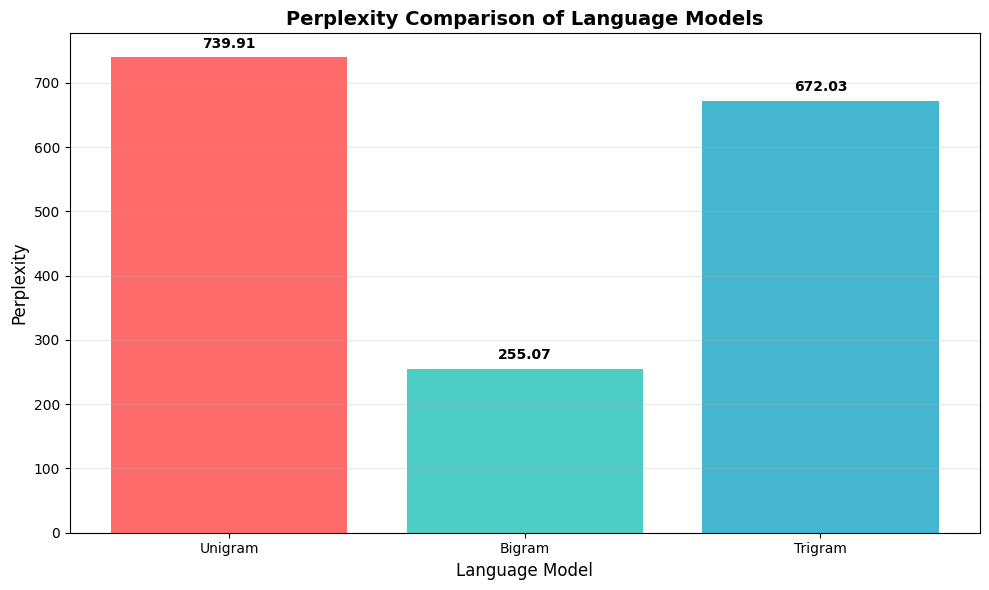


✓ Perplexity evaluation complete!
✓ Graph saved as 'perplexity_comparison.png'


In [ ]:
import math
import matplotlib.pyplot as plt

def calculate_perplexity(model, test_tokens, model_type='unigram'):
    """
    Calculate perplexity of a language model on test data.

    Perplexity = exp(-1/N * sum(log P(w_i | context)))
    Lower perplexity = better model
    """
    log_prob_sum = 0
    N = len(test_tokens)

    if model_type == 'unigram':
        for token in test_tokens:
            prob = model.probability(token)
            # With smoothing, prob should never be 0
            if prob > 0:
                log_prob_sum += math.log2(prob)  # Use log2 for better numerical stability
            else:
                log_prob_sum += math.log2(1e-10)

    elif model_type == 'bigram':
        tokens = ['<START>'] + test_tokens
        for i in range(len(tokens) - 1):
            prob = model.probability(tokens[i], tokens[i+1])
            if prob > 0:
                log_prob_sum += math.log2(prob)
            else:
                log_prob_sum += math.log2(1e-10)

    elif model_type == 'trigram':
        tokens = ['<START>', '<START>'] + test_tokens
        for i in range(len(tokens) - 2):
            w1, w2, w3 = tokens[i], tokens[i+1], tokens[i+2]

            # Try trigram first
            prob = model.probability(w1, w2, w3)

            # If trigram probability is too low, use backoff
            if prob < 1e-10:
                # Backoff to bigram
                if model.bigram_model:
                    prob = model.bigram_model.probability(w2, w3)
                    if prob < 1e-10 and model.unigram_model:
                        # Backoff to unigram
                        prob = model.unigram_model.probability(w3)

            if prob > 0:
                log_prob_sum += math.log2(prob)
            else:
                log_prob_sum += math.log2(1e-10)

    # Calculate perplexity using log2
    perplexity = 2 ** (-log_prob_sum / N)
    return perplexity


# Prepare test data (use a subset of articles not used in training)
test_size = min(20, len(lemmatized_articles) // 10)
test_article_ids = sorted(lemmatized_articles.keys())[-test_size:]
test_tokens = []
for aid in test_article_ids:
    test_tokens.extend(lemmatized_articles[aid])

print(f"Test set size: {len(test_tokens)} tokens from {test_size} articles")
print("\nCalculating perplexity scores...\n")

# Calculate perplexity for each model
unigram_perplexity = calculate_perplexity(unigram_model, test_tokens, 'unigram')
bigram_perplexity = calculate_perplexity(bigram_model, test_tokens, 'bigram')
trigram_perplexity = calculate_perplexity(trigram_model, test_tokens, 'trigram')

print("Perplexity Scores:")
print(f"  Unigram Model: {unigram_perplexity:.2f}")
print(f"  Bigram Model:  {bigram_perplexity:.2f}")
print(f"  Trigram Model: {trigram_perplexity:.2f}")

# Visualization
models = ['Unigram', 'Bigram', 'Trigram']
perplexities = [unigram_perplexity, bigram_perplexity, trigram_perplexity]

plt.figure(figsize=(10, 6))
plt.bar(models, perplexities, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.xlabel('Language Model', fontsize=12)
plt.ylabel('Perplexity', fontsize=12)
plt.title('Perplexity Comparison of Language Models', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(perplexities):
    plt.text(i, v + max(perplexities)*0.02, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('perplexity_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Perplexity evaluation complete!")
print("✓ Graph saved as 'perplexity_comparison.png'")